In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys

from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score

In [22]:
sys.setrecursionlimit(1000000000)

In [76]:
%matplotlib inline
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (16, 7)})

In [3]:
arena_news_stem_df = pd.read_pickle('arena_news_stem_df_plus.pkl')
sport_news_stem_df = pd.read_pickle('sport_news_stem_df_plus.pkl')
jovem_news_stem_df = pd.read_pickle('jovem_news_stem_df_plus.pkl')
arena_news_df = pd.read_pickle('arena_news_df_plus.pkl')
sport_news_df = pd.read_pickle('sport_news_df_plus.pkl')
jovem_news_df = pd.read_pickle('jovem_news_df_plus.pkl')

In [4]:
labels = np.array(len(arena_news_df)*[1] + len(sport_news_df)*[0])

In [5]:
count_vect = CountVectorizer(encoding='UTF-8',lowercase=False,min_df=2)
X = count_vect.fit_transform(arena_news_df['all'].tolist() + sport_news_df['all'].tolist())

X_train_norm_tfidf = TfidfTransformer(norm=u'l2', use_idf=True).fit_transform(X)
X_train_norm = TfidfTransformer(norm=u'l2', use_idf=False).fit_transform(X)

In [153]:
def _big_s(x, center):
    len_x = len(x)
    total = 0

    for i in range(len_x):
        total += np.linalg.norm(x[i]-center)

    return total / len_x

def davies_bouldin_score(X, labels_pred, k_centers):
    num_clusters, _ = k_centers.shape
    big_ss = np.zeros([num_clusters], dtype=np.float64)
    d_eucs = np.zeros([num_clusters, num_clusters], dtype=np.float64)
    db = 0

    for k in range(num_clusters):
        samples_in_k_inds = np.where(labels_pred == k)[0]
        samples_in_k = X[samples_in_k_inds, :]
        big_ss[k] = _big_s(samples_in_k, k_centers[k])

    for k in range(num_clusters):
        for l in range(0, num_clusters):
            d_eucs[k, l] = np.linalg.norm(k_centers[k]-k_centers[l])

    for k in range(num_clusters):
        values = np.zeros([num_clusters-1], dtype=np.float64)
        for l in range(0, k):
            values[l] = (big_ss[k] + big_ss[l])/d_eucs[k, l]
        for l in range(k+1, num_clusters):
            values[l-1] = (big_ss[k] + big_ss[l])/d_eucs[k, l]

        db += np.max(values)
    res = db / num_clusters
    return res

In [17]:
def onmtf(X, U, S, V):
    U = U * (X.dot(V).dot(S.T)) / (U.dot(S).dot(V.T).dot(X.T).dot(U))
    S = S * (U.T.dot(X).dot(V)) / (U.T.dot(U).dot(S).dot(V.T).dot(V))
    V = V * (X.T.dot(U).dot(S)) / (V.dot(S.T).dot(U.T).dot(X).dot(V))
    return U, S, V

def onm3f(X, U, S, V):
     U = U * (X.dot(V).dot(S.T)) / np.sqrt(U.dot(U.T).dot(X).dot(V).dot(S.T))
     V = V * (X.T.dot(U).dot(S)) / np.sqrt(V.dot(V.T).dot(X.T).dot(U).dot(S))
     S = S * (U.T.dot(X).dot(V)) / np.sqrt(U.T.dot(U).dot(S).dot(V.T).dot(V))
     return U, S, V

def nbvd(X, U, S, V):
     U = U * (X.dot(V).dot(S.T)) / U.dot(U.T).dot(X).dot(V).dot(S.T)
     V = V * (X.T.dot(U).dot(S)) / V.dot(V.T).dot(X.T).dot(U).dot(S)
     S = S * (U.T.dot(X).dot(V)) / U.T.dot(U).dot(S).dot(V.T).dot(V)
     return U, S, V
    
def matrix_factorization_clustering(X, k, l, factorization_func=onmtf, norm=False, num_iters=100):
    m, n = X.shape
    U = np.random.rand(m,k)
    S = np.random.rand(k,l)
    V = np.random.rand(n,l)

    if norm:
        X = normalize(X)

    for i in xrange(num_iters):
        U, S, V = factorization_func(X, U, S, V)

    Du = np.diag(np.ones(m).dot(U))
    Dv = np.diag(np.ones(n).dot(V))

    U = U.dot( np.diag(S.dot(Dv).dot(np.ones(l))) )
    V = V.dot( np.diag(np.ones(k).dot(Du).dot(S)) )

    rows_ind = np.argmax(U, axis=1)
    cols_ind = np.argmax(V, axis=1)

    return U, S, V, rows_ind, cols_ind

In [18]:
def fnmtf(X, k, l, num_iter=100, norm=False):
    m, n = X.shape

    U = np.random.rand(m,k)
    S = np.random.rand(k,l)
    V = np.random.rand(n,l)

    if norm:
        X = preprocessing.normalize(X)
    for i in xrange(num_iter):
        S = np.linalg.pinv(U.T.dot(U)).dot(U.T).dot(X).dot(V).dot(np.linalg.pinv(V.T.dot(V)))

        # solve subproblem to update V
        U_tilde = U.dot(S)
        V_new = np.zeros(n*l).reshape(n, l)
        for j in xrange(n):
            errors = np.zeros(l)
            for col_clust_ind in xrange(l):
                errors[col_clust_ind] = ((X[:][:, j] - U_tilde[:][:, col_clust_ind])**2).sum()
            ind = np.argmin(errors)
            V_new[j][ind] = 1

        # solve subproblem to update U
        V_tilde = S.dot(V.T)
        U_new = np.zeros(m*k).reshape(m, k)
        for i in xrange(m):
            errors = np.zeros(k)
            for row_clust_ind in xrange(k):
                errors[row_clust_ind] = ((X[i][:] - V_tilde[row_clust_ind][:])**2).sum()
            ind = np.argmin(errors)
            U_new[i][ind] = 1

        U = U_new
        V = V_new

    rows_ind = np.argmax(U, axis=1)
    cols_ind = np.argmax(V, axis=1)

    return U, S, V, rows_ind, cols_ind

In [70]:
def rand_score(labels_true, labels_pred):
    return 'Rand score: %s' % adjusted_rand_score(labels_true, labels_pred)

def sil_score(X, labels_pred):
    score = silhouette_score(X, labels_pred)
    return 'Silhouette score: %s' % score

def db_score(X, labels_pred, k_centers):
    return 'Davies-Bouldin index: %s' % davies_bouldin_score(X, labels_pred, k_centers)

In [222]:
best = 0
for _ in xrange(5):
    U_t, S_t, V_t, rows_ind_t, cols_ind_t = matrix_factorization_clustering(X_train_norm.toarray(), 2, 2, onmtf, num_iters=100)
    rand_sc = adjusted_rand_score(labels, rows_ind_t)
    if rand_sc > best:
        best = rand_sc
        U = U_t
        S = S_t
        V = V_t
        rows_ind = rows_ind_t
        cols_ind = cols_ind_t
    print 'tf norm: %s' % rand_score(labels, rows_ind_t)
    print 'tf norm: %s' % sil_score(X_train_norm, rows_ind_t)
    print 'tf norm: %s' % db_score(X_train_norm.toarray(), rows_ind_t, S.dot(V.T))
    print ''

tf norm: Rand score: 0.962793338387
tf norm: Silhouette score: 0.0268220112766
tf norm: Davies-Bouldin index: 1.63464836862

tf norm: Rand score: 0.962793338387
tf norm: Silhouette score: 0.0268220112766
tf norm: Davies-Bouldin index: 1.63464919356

tf norm: Rand score: 0.962793338387
tf norm: Silhouette score: 0.0268220112766
tf norm: Davies-Bouldin index: 1.63464919356



KeyboardInterrupt: 

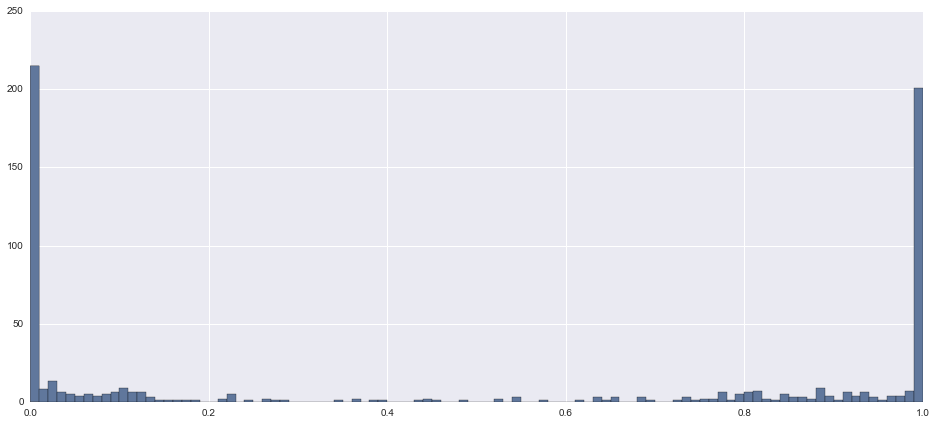

In [239]:
def print_hist(U):
    _, k = U.shape
    U_norm = U[:, 0] / np.sum(U, axis=1)
    
    plt.title('U norm 0')
    plt.hist(U_norm, bins=100)
    plt.show()
print_hist(U)

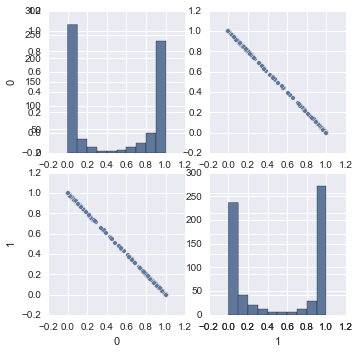

In [240]:
def norm(U):
    _, k = U.shape
    return U / np.tile(np.sum(U, axis=1).T, (k,1)).T
def pairplot(U):
    sns.pairplot(pd.DataFrame(norm(U)))
pairplot(U)

In [241]:
best_sil = 1e-10
best_davies = 1e10
for down_lim in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    for up_lim in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
        new_labels_pred = rows_ind.copy()
        inds = np.where((norm(U)[:,0] >= down_lim) & (norm(U)[:,0] <= up_lim))[0]
        
        if len(inds) == 0:
            continue
        
        print 'Num elems in new cluster: %s' % len(inds)
        new_labels_pred[inds] = 2

        print 'cluster from ' + str(down_lim) + ' to ' + str(up_lim)
        print sil_score(X_train_norm, new_labels_pred)
        print db_score(X_train_norm.toarray(), new_labels_pred, S.dot(V.T))
        print ''
        davies = davies_bouldin_score(X_train_norm.toarray(), new_labels_pred, S.dot(V.T))
        sil = silhouette_score(X_train_norm, new_labels_pred)
        if sil > best_sil and len(inds) is not 0:
            best_sil = sil
        if davies < best_davies and len(inds) is not 0:
            best_davies = davies
#         print '|[%s, %s]| %s | %s |' % (down_lim, up_lim, davies, sil)
print 'Best sil score: %s' % best_sil
print 'Best davies score: %s' % best_davies


Num elems in new cluster: 24
cluster from 0.05 to 0.1
Silhouette score: 0.0131939870554
Davies-Bouldin index: 1.63464836421

Num elems in new cluster: 49
cluster from 0.05 to 0.15
Silhouette score: 0.0128677949482
Davies-Bouldin index: 1.63464836119

Num elems in new cluster: 53
cluster from 0.05 to 0.2
Silhouette score: 0.0132111930353
Davies-Bouldin index: 1.63464835866

Num elems in new cluster: 61
cluster from 0.05 to 0.25
Silhouette score: 0.0135981849943
Davies-Bouldin index: 1.63464835408

Num elems in new cluster: 65
cluster from 0.05 to 0.3
Silhouette score: 0.0136221287299
Davies-Bouldin index: 1.6346483527

Num elems in new cluster: 70
cluster from 0.05 to 0.4
Silhouette score: 0.0141210724006
Davies-Bouldin index: 1.63464834733

Num elems in new cluster: 75
cluster from 0.05 to 0.5
Silhouette score: 0.0144689359503
Davies-Bouldin index: 1.63464834146

Num elems in new cluster: 81
cluster from 0.05 to 0.6
Silhouette score: 0.0144323118725
Davies-Bouldin index: 1.63464833878


|      Cut      |    Davies     | Silhouette  |
|:-------------:|:-------------:|:-----:|
|[0.2, 0.3]| 1.63206334851 | 0.0170302136701 |
|[0.2, 0.4]| 1.6320633406 | 0.0188368402443 |
|[0.2, 0.5]| 1.63206333812 | 0.0181812861725 |
|[0.2, 0.6]| 1.63206333505 | 0.0182496293806 |
|[0.2, 0.7]| 1.63206333206 | 0.0182788602025 |
|[0.2, 0.75]| 1.63206333127 | 0.0176717463632 |
|[0.2, 0.8]| 1.63206332839 | 0.0171676859755 |
|[0.2, 0.85]| 1.63206332668 | 0.0171347854363 |
|[0.2, 0.9]| 1.63206332338 | 0.015277385074 |
|**[0.2, 0.95]**| **1.63206331953** | 0.0146721613182 |
|**[0.3, 0.4]**| 1.63206334908 | **0.0203214004136** |
|[0.3, 0.5]| 1.63206334694 | 0.0180394197208 |
|[0.3, 0.6]| 1.63206334387 | 0.0180920648375 |
|[0.3, 0.7]| 1.63206334088 | 0.0181680222463 |
|[0.3, 0.75]| 1.63206334009 | 0.0172711503904 |
|[0.3, 0.8]| 1.63206333722 | 0.0167689770711 |
|[0.3, 0.85]| 1.6320633355 | 0.0168353296156 |
|[0.3, 0.9]| 1.6320633322 | 0.0151297600769 |
|[0.3, 0.95]| 1.63206332835 | 0.0148090559579 |
|[0.4, 0.5]| 1.63206335423 | 0.0116222130607 |
|[0.4, 0.6]| 1.63206335116 | 0.0144558601793 |
|[0.4, 0.7]| 1.63206334817 | 0.0157336578169 |
|[0.4, 0.75]| 1.63206334738 | 0.0147616732479 |
|[0.4, 0.8]| 1.6320633445 | 0.0148811517773 |
|[0.4, 0.85]| 1.63206334278 | 0.0152615911554 |
|[0.4, 0.9]| 1.63206333949 | 0.0142575280731 |
|[0.4, 0.95]| 1.63206333564 | 0.0142983610145 |
|[0.5, 0.6]| 1.63206335308 | 0.0168053212842 |
|[0.5, 0.7]| 1.63206335009 | 0.0174941090121 |
|[0.5, 0.75]| 1.6320633493 | 0.0154384141321 |
|[0.5, 0.8]| 1.63206334643 | 0.0152361306211 |
|[0.5, 0.85]| 1.63206334471 | 0.0156384893486 |
|[0.5, 0.9]| 1.63206334141 | 0.0143047943129 |
|[0.5, 0.95]| 1.63206333756 | 0.0143292896173 |
|[0.6, 0.7]| 1.63206335325 | 0.0175607470043 |
|[0.6, 0.75]| 1.63206335251 | 0.0139532264764 |
|[0.6, 0.8]| 1.63206334977 | 0.0143772037858 |
|[0.6, 0.85]| 1.63206334813 | 0.0150242258351 |
|[0.6, 0.9]| 1.63206334524 | 0.0138256549357 |
|[0.6, 0.95]| 1.63206334182 | 0.013986761675 |
|[0.7, 0.75]| 1.63206335546 | 0.00901638693935 |
|[0.7, 0.8]| 1.63206335283 | 0.012787243572 |
|[0.7, 0.85]| 1.63206335126 | 0.0138615914924 |
|[0.7, 0.9]| 1.63206334874 | 0.0131225257941 |
|[0.7, 0.95]| 1.6320633457 | 0.0134793155216 |
|[0.75, 0.8]| 1.63206335358 | 0.0142925246246 |
|[0.75, 0.85]| 1.63206335203 | 0.0151228085039 |
|[0.75, 0.9]| 1.63206334962 | 0.0131665006411 |
|[0.75, 0.95]| 1.63206334671 | 0.0134358355033 |
|[0.8, 0.85]| 1.63206335467 | 0.0161534462294 |
|[0.8, 0.9]| 1.63206335259 | 0.0125688529289 |
|[0.8, 0.95]| 1.63206335002 | 0.0130225829836 |
|[0.85, 0.9]| 1.63206335423 | 0.0119223678382 |
|[0.85, 0.95]| 1.63206335184 | 0.0126827147301 |
|[0.9, 0.95]| 1.63206335413 | 0.012628788748 |

In [250]:
rows_inds_v1 = rows_ind.copy()
inds = np.where((norm(U)[:,0] >= 0.05) & (norm(U)[:,0] <= 0.95))[0]
rows_inds_v1[inds] = 2
rows_inds_v1

array([2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2,
       2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2,
       0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0,
       0, 0,

In [254]:
best = 1e10
for _ in xrange(3):
    U_t, S_t, V_t, rows_ind_t, cols_ind_t = matrix_factorization_clustering(X_train_norm.toarray(), 3, 2, onmtf, num_iters=100)
    try:
        dav_sc = davies_bouldin_score(X_train_norm.toarray(), rows_ind_t, S_t.dot(V_t.T))
    except:
        continue
    if dav_sc < best:
        best = dav_sc
        U_v2 = U_t
        S_v2 = S_t
        V_v2 = V_t
        rows_ind_v2 = rows_ind_t
        cols_ind_v2 = cols_ind_t

    print 'tf norm (3 clusters): %s' % rand_score(labels, rows_ind_t)
    print 'tf norm (3 clusters): %s' % sil_score(X_train_norm, rows_ind_t)
    print 'tf norm (3 clusters): %s' % dav_sc
    print ''

tf norm (3 clusters): Rand score: 0.953667051037
tf norm (3 clusters): Silhouette score: 0.0112488164138
tf norm (3 clusters): 1.50765509543

tf norm (3 clusters): Rand score: 0.854426780664
tf norm (3 clusters): Silhouette score: 0.0145335019017
tf norm (3 clusters): 2.96785651894

tf norm (3 clusters): Rand score: 0.365282122327
tf norm (3 clusters): Silhouette score: 0.0229882190762
tf norm (3 clusters): 7.48245284526



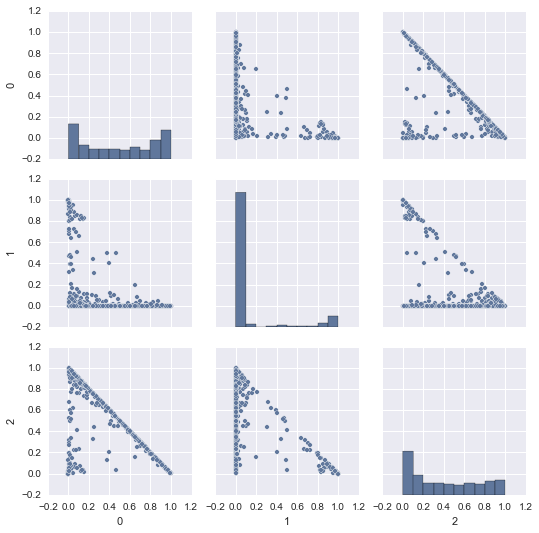

In [257]:
pairplot(U_t)

In [259]:
print 'Num elems in cluster 0: %s' % np.sum(rows_ind_t == 0)
print 'Num elems in cluster 1: %s' % np.sum(rows_ind_t == 1)
print 'Num elems in cluster 2: %s' % np.sum(rows_ind_t == 2)
print rows_ind_v2

Num elems in cluster 0: 318
Num elems in cluster 1: 75
Num elems in cluster 2: 247
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 1 

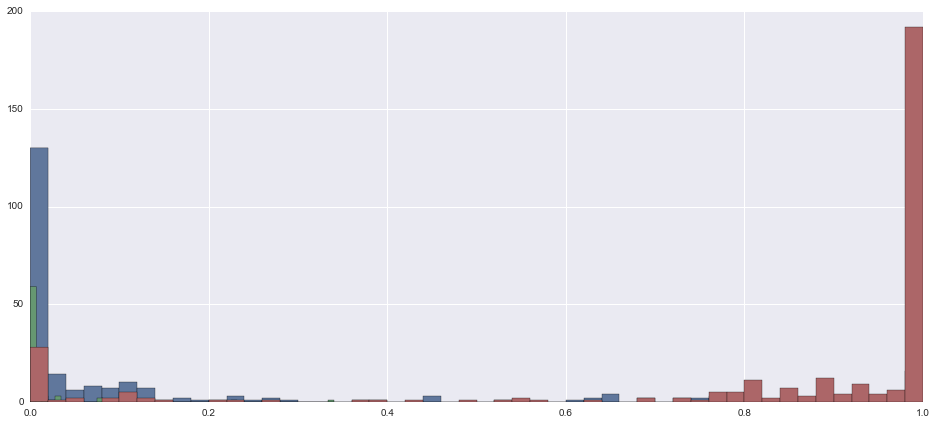

In [263]:
plt.hold()
inds = np.where(rows_ind_t == 2)[0]
plt.hist(norm(U)[inds, 0], bins=50)

inds = np.where(rows_ind_t == 1)[0]
plt.hist(norm(U)[inds, 0], bins=50)

inds = np.where(rows_ind_t == 0)[0]
plt.hist(norm(U)[inds, 0], bins=50)
plt.show()

In [253]:
def overlap(a, b, k, l):
    clust_a = a == k
    clust_b = b == l
    
    inds = []
    sum_all = 0
    sum_equals = 0
    for i, elem in enumerate(clust_a):
        if (clust_a[i] == False and clust_b[i] == False):
            continue
        elif (clust_a[i] == True and clust_b[i] == False):
            sum_all += 1
        elif (clust_a[i] == False and clust_b[i] == True):
            sum_all += 1
        elif (clust_a[i] == True and clust_b[i] == True):
            sum_equals += 1
            sum_all += 1
            inds.append(i)
    return np.array(inds), float(sum_equals) / sum_all
print 'Do they overlap on cluster 2?'
inds, overlap_rate = overlap(rows_inds_v1, rows_ind_v2, 2, 0)
print '%.2f' % overlap_rate
print inds

Do they overlap on cluster 2?
0.08
[ 11  34  66  83  90  94  95 103 133 145 150 158 166 175 201 229 234 235
 285 297]


In [ ]:
U, S, V, rows_ind, cols_ind = fnmtf(X, 3, 3, norm=True)